## Liquidity Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression

sns.set_theme(style="whitegrid")

In [19]:
df_liquidity = pd.read_csv("../csv_outputs/master_liquidity.csv")
df_lp_holders = pd.read_csv("../csv_outputs/master_lp_holders.csv")
df_liquidity.columns

Index(['token_address', 'chain', 'token_name', 'price_usd', 'liquidity_usd',
       'market_cap_usd', 'liquidity_to_market_cap_ratio', 'token_volume',
       'volume_usd', 'volume_to_liquidity_ratio', 'locked_liquidity_percent',
       'locked_95_for_15_days', 'creator_under_5_percent',
       'creator_percent_of_lp', 'owner_under_5_percent', 'owner_percent_of_lp',
       'total_lp_supply', 'lp_holders_count', 'error'],
      dtype='object')

In [3]:
# Convert 'percent' from decimal (e.g. 0.009) to percentage (e.g. 0.9%)
df_lp_holders['percent'] = df_lp_holders['percent'] * 100

# Round the 'percent' column to 4 decimal places for clean presentation and calculations
df_lp_holders['percent'] = df_lp_holders['percent'].round(4)

# Now group by token_address
grouped = df_lp_holders.groupby("token_address")

# Aggregate summary stats for each token
summary = grouped.agg({
    "balance": "sum",         # total LP balance
    "percent": "sum",         # total percentage (should now be close to 100%)
    "address": "count",       # number of LP holders
    "is_locked": "sum"        # number of locked holders (True counts as 1)
}).rename(columns={
    "balance": "total_balance",
    "percent": "total_percent",
    "address": "num_holders",
    "is_locked": "num_locked"
})

# Reset index so token_address is a column again
summary = summary.reset_index()

# View result
summary.head()


,token_address,total_balance,total_percent,num_holders,num_locked
0,0x002127Ec60f4b0F75F7AE20565D1d0cd99993dD3,1.000000e-15,1.000000e+02,1,True
1,0x002A029d13f423227A24641CD5Fec448A52FEa32,2.690819e-03,1.000000e+02,2,1
2,0x0079C34BaDa93B2ff613913Cde64E53aE6168fBa,1.012206e-03,1.000000e+02,2,1
3,0x007C5Ade505C1455a072207b0C5b9CF3Ac79B251,2.846050e+03,3.386768e+08,2,1
4,0x008B19CF90896BB20c4619c59Ef4c2bC55B7674e,1.122714e-03,1.000000e+02,2,1


/tmp/ipykernel_744466/3683660773.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['total_lp_supply'] = df_filtered['total_lp_supply'].astype(float)


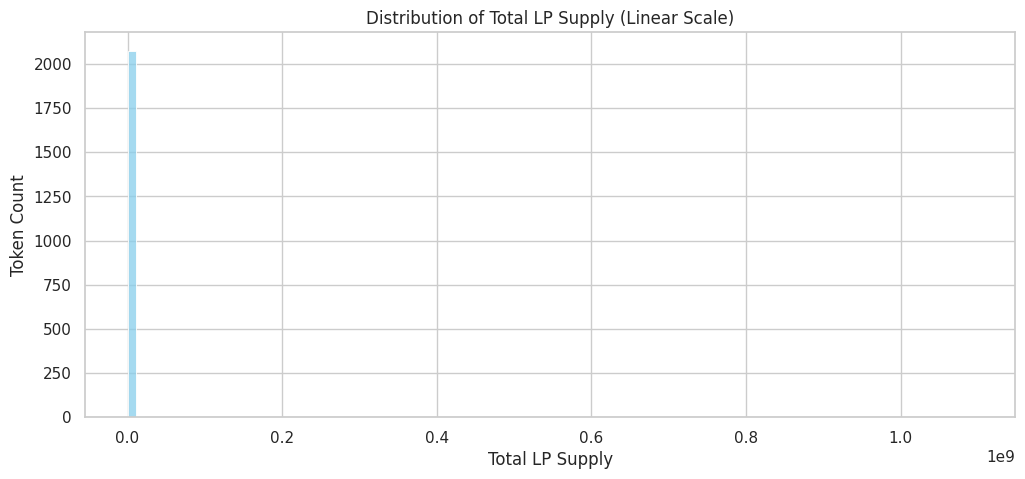

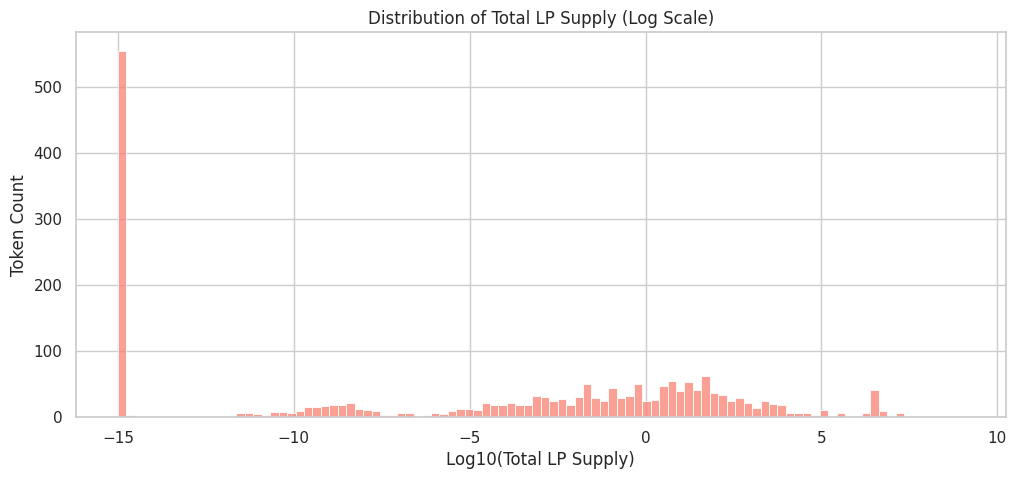

In [22]:
# Drop rows with missing or invalid 'total_lp_supply' values
df_filtered = df_liquidity[pd.to_numeric(df_liquidity['total_lp_supply'], errors='coerce').notnull()]
df_filtered['total_lp_supply'] = df_filtered['total_lp_supply'].astype(float)

# Plot distribution (linear scale)
plt.figure(figsize=(12, 5))
sns.histplot(df_filtered['total_lp_supply'], bins=100, kde=False, color='skyblue')
plt.title('Distribution of Total LP Supply (Linear Scale)')
plt.xlabel('Total LP Supply')
plt.ylabel('Token Count')
plt.grid(True)
plt.show()

# Plot distribution (log scale)
plt.figure(figsize=(12, 5))
# Avoid log(0) and negative values
log_data = df_filtered[df_filtered['total_lp_supply'] > 0]['total_lp_supply']
sns.histplot(np.log10(log_data), bins=100, kde=False, color='salmon')
plt.title('Distribution of Total LP Supply (Log Scale)')
plt.xlabel('Log10(Total LP Supply)')
plt.ylabel('Token Count')
plt.grid(True)
plt.show()

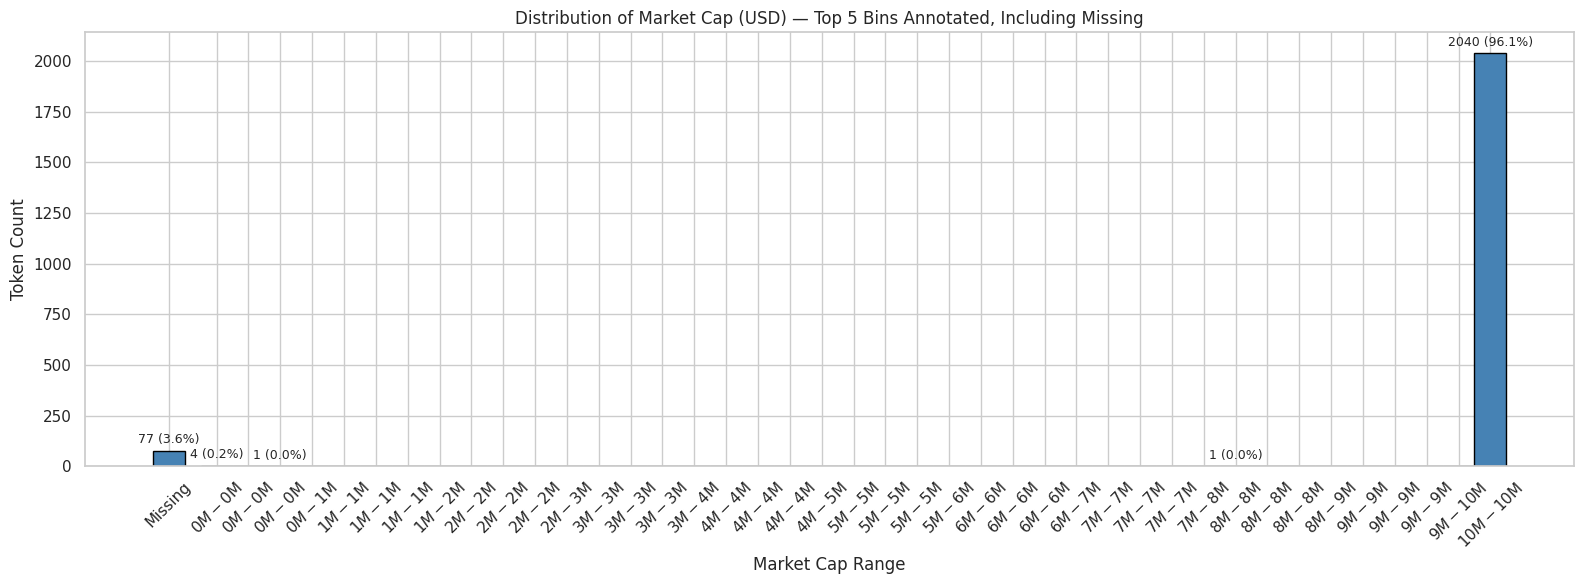

In [26]:
# Clean and prepare the data
df_liquidity['market_cap_usd_cleaned'] = pd.to_numeric(df_liquidity['market_cap_usd'], errors='coerce')
market_cap_data = df_liquidity['market_cap_usd_cleaned'].dropna()
missing_count = df_liquidity['market_cap_usd_cleaned'].isna().sum()

# Optional: clip extremely high values for readability (e.g., cap at $10M)
market_cap_data_clipped = market_cap_data.clip(upper=1e7)

# Create bins (e.g., $0 to $10M in $250k increments)
bin_edges = np.arange(0, 1.05e7, 2.5e5)
counts, edges = np.histogram(market_cap_data_clipped, bins=bin_edges)
bin_centers = 0.5 * (edges[:-1] + edges[1:])

# Add missing values as its own bin
bin_centers = np.insert(bin_centers, 0, -2.5e5)  # Use negative x for "Missing"
counts = np.insert(counts, 0, missing_count)
labels = ['Missing'] + [f"${int(edges[i]/1e6):,}M-${int(edges[i+1]/1e6):,}M" for i in range(len(edges)-1)]
total = counts.sum()

# Identify top 5 bins by count
top_5_indices = np.argsort(counts)[-5:]

# Plot
plt.figure(figsize=(16, 6))
bars = plt.bar(bin_centers, counts, width=2.5e5, color='steelblue', edgecolor='black')

# Annotate only top 5 bins
for i, bar in enumerate(bars):
    if i in top_5_indices and counts[i] > 0:
        percentage = (counts[i] / total) * 100
        plt.text(bar.get_x() + bar.get_width() / 2,
                 bar.get_height() + total * 0.01,
                 f'{counts[i]} ({percentage:.1f}%)',
                 ha='center', va='bottom', fontsize=9)

# Set custom x-axis ticks and labels
xticks = bin_centers
xlabels = labels
plt.xticks(ticks=xticks, labels=xlabels, rotation=45)

# Labels and title
plt.title("Distribution of Market Cap (USD) — Top 5 Bins Annotated, Including Missing")
plt.xlabel("Market Cap Range")
plt.ylabel("Token Count")
plt.tight_layout()
plt.show()

## Market cap and liquidity pool depth

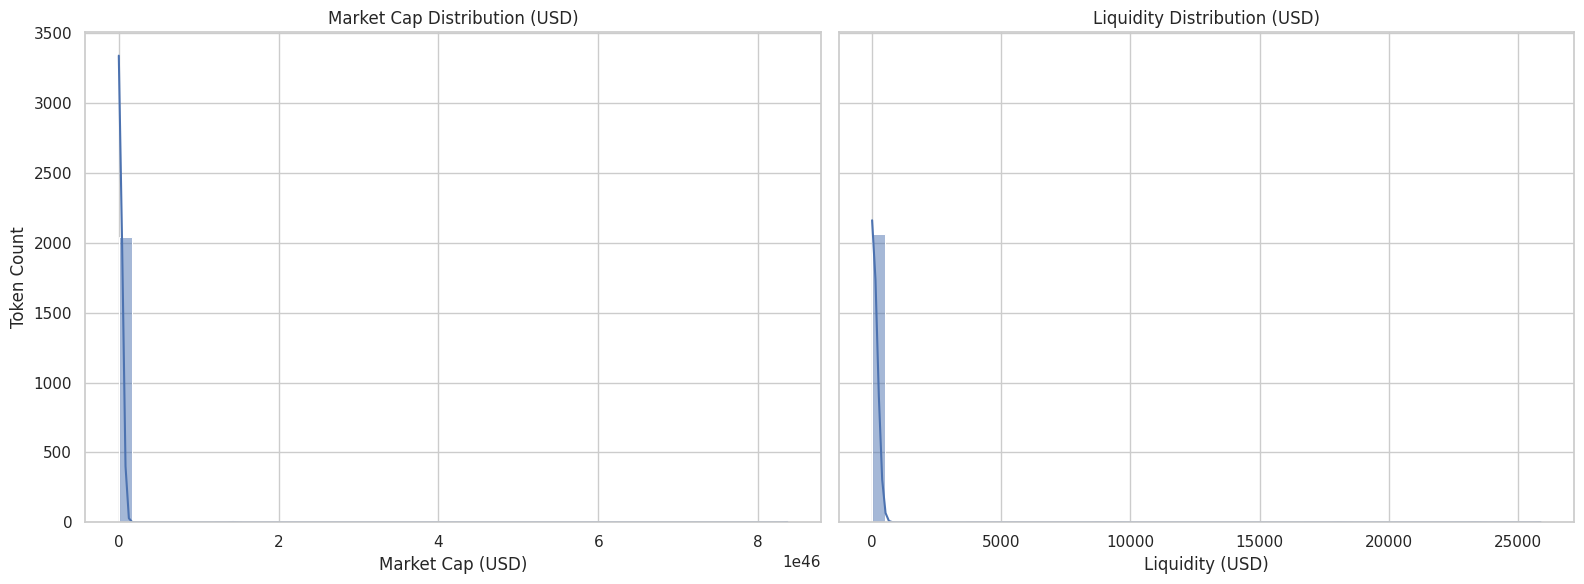

In [6]:
# Set up side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Market Cap plot
sns.histplot(ax=axes[0], x=df_liquidity['market_cap_usd'], bins=50, kde=True)
axes[0].set_title('Market Cap Distribution (USD)')
axes[0].set_xlabel('Market Cap (USD)')
axes[0].set_ylabel('Token Count')

# Liquidity plot
sns.histplot(ax=axes[1], x=df_liquidity['liquidity_usd'], bins=50, kde=True)
axes[1].set_title('Liquidity Distribution (USD)')
axes[1].set_xlabel('Liquidity (USD)')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

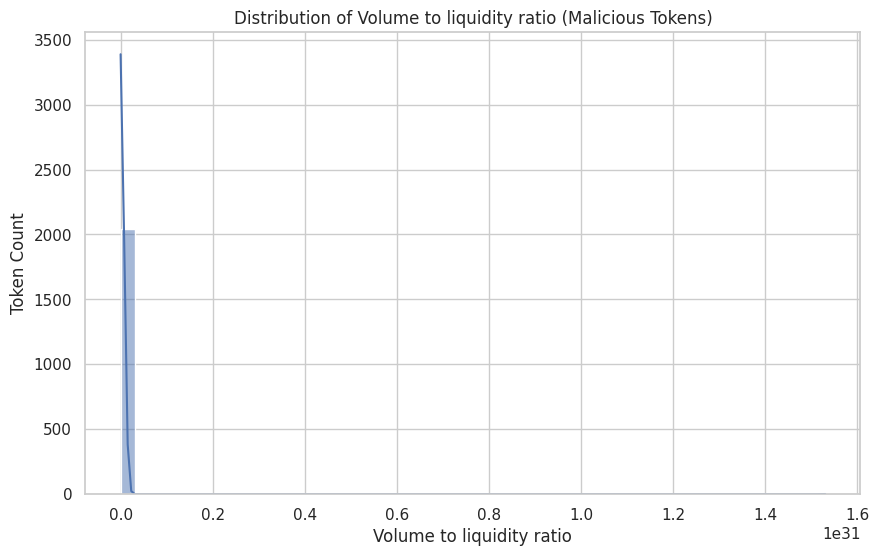

In [7]:
plt.figure(figsize=(10, 6))
sns.histplot(df_liquidity['volume_to_liquidity_ratio'], bins=50, kde=True)
plt.title('Distribution of Volume to liquidity ratio (Malicious Tokens)')
plt.xlabel('Volume to liquidity ratio')
plt.ylabel('Token Count')
plt.show()



## At least 95% of largest pool's liquidity token burned/locked for 15 days or longer

/tmp/ipykernel_744466/1526592353.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=locked_counts.index.astype(str), y=locked_counts.values, palette='pastel')


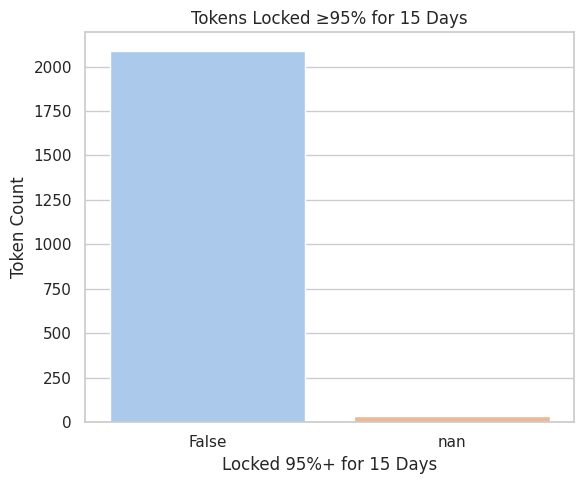

In [8]:
# Clean the column: Convert string to boolean
df_liquidity['locked_95_for_15_days_cleaned'] = df_liquidity['locked_95_for_15_days'].astype(str).str.strip().str.lower().map({
    'true': True,
    'false': False
})

# Count the values
locked_counts = df_liquidity['locked_95_for_15_days_cleaned'].value_counts(dropna=False)

# Plot
plt.figure(figsize=(6, 5))
sns.barplot(x=locked_counts.index.astype(str), y=locked_counts.values, palette='pastel')
plt.title('Tokens Locked ≥95% for 15 Days')
plt.xlabel('Locked 95%+ for 15 Days')
plt.ylabel('Token Count')
plt.tight_layout()
plt.show()

## Owner/creator wallet contains less than 5% of liquidity

/tmp/ipykernel_744466/3992226970.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=locked_counts.index.astype(str), y=locked_counts.values, palette='pastel')


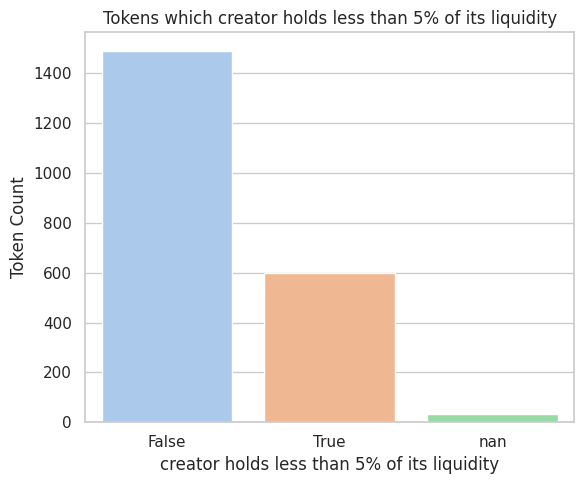

In [9]:
# Clean the column: Convert string to boolean
df_liquidity['creator_under_5_percent_cleaned'] = df_liquidity['creator_under_5_percent'].astype(str).str.strip().str.lower().map({
    'true': True,
    'false': False
})

# Count the values
locked_counts = df_liquidity['creator_under_5_percent_cleaned'].value_counts(dropna=False)

# Plot
plt.figure(figsize=(6, 5))
sns.barplot(x=locked_counts.index.astype(str), y=locked_counts.values, palette='pastel')
plt.title('Tokens which creator holds less than 5% of its liquidity')
plt.xlabel('creator holds less than 5% of its liquidity')
plt.ylabel('Token Count')
plt.tight_layout()
plt.show()

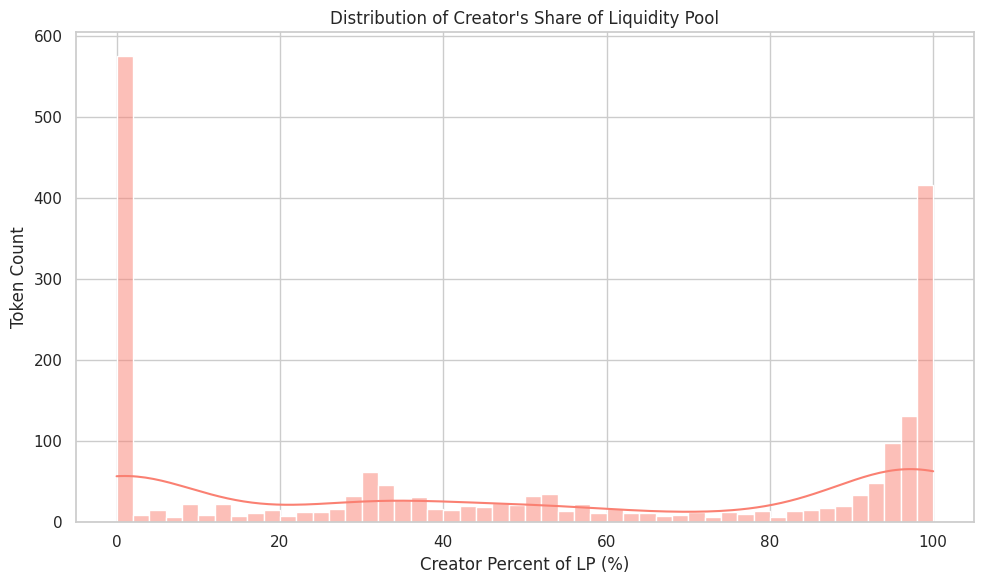

In [10]:
# Optional: Clip values to 0–100% to avoid invalid extremes
df_liquidity['creator_percent_of_lp_clipped'] = pd.to_numeric(df_liquidity['creator_percent_of_lp'], errors='coerce').clip(0, 100)

plt.figure(figsize=(10, 6))
sns.histplot(df_liquidity['creator_percent_of_lp_clipped'], bins=50, kde=True, color='salmon')
plt.title('Distribution of Creator\'s Share of Liquidity Pool')
plt.xlabel('Creator Percent of LP (%)')
plt.ylabel('Token Count')
plt.tight_layout()
plt.show()

/tmp/ipykernel_744466/2115287681.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=locked_counts.index.astype(str), y=locked_counts.values, palette='pastel')


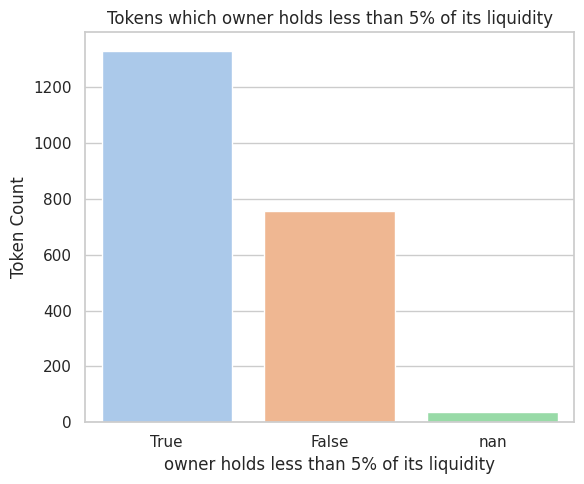

In [11]:

# Clean the column: Convert string to boolean
df_liquidity['owner_under_5_percent_cleaned'] = df_liquidity['owner_under_5_percent'].astype(str).str.strip().str.lower().map({
    'true': True,
    'false': False
})

# Count the values
locked_counts = df_liquidity['owner_under_5_percent_cleaned'].value_counts(dropna=False)

# Plot
plt.figure(figsize=(6, 5))
sns.barplot(x=locked_counts.index.astype(str), y=locked_counts.values, palette='pastel')
plt.title('Tokens which owner holds less than 5% of its liquidity')
plt.xlabel('owner holds less than 5% of its liquidity')
plt.ylabel('Token Count')
plt.tight_layout()
plt.show()

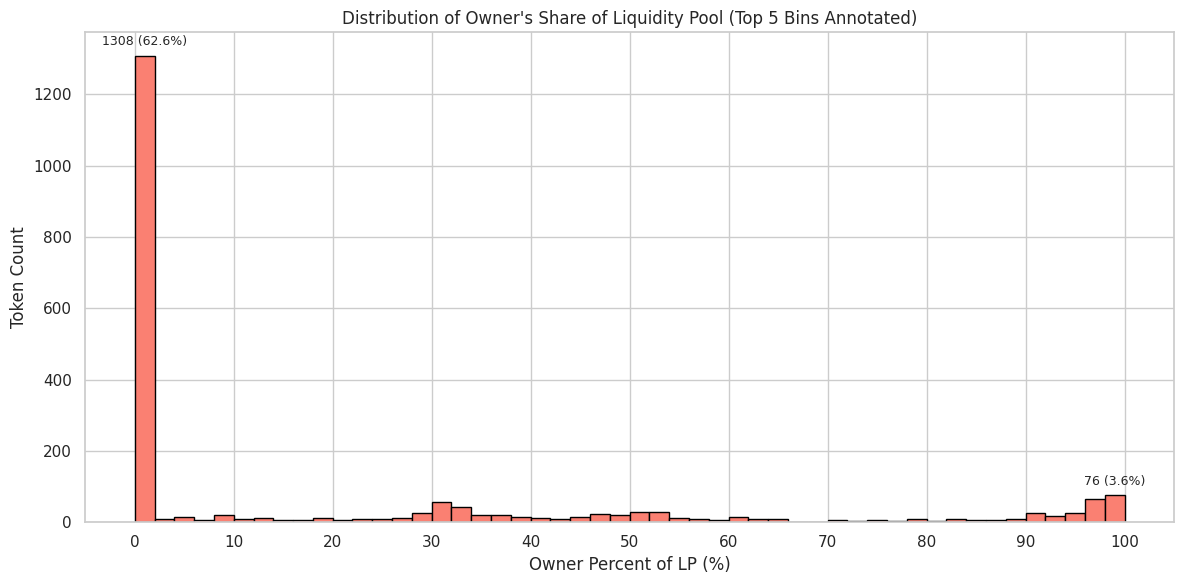

In [12]:
# Ensure data is numeric and clipped to [0, 100]
df_liquidity['owner_percent_of_lp_clipped'] = pd.to_numeric(df_liquidity['owner_percent_of_lp'], errors='coerce').clip(0, 100)

# Generate histogram data
owner_data = df_liquidity['owner_percent_of_lp_clipped'].dropna()
bin_edges = np.linspace(0, 100, 51)  # 50 bins from 0 to 100
counts, edges = np.histogram(owner_data, bins=bin_edges)
bin_centers = 0.5 * (edges[:-1] + edges[1:])
total = counts.sum()

# Identify top 5 bins by count
top_5_indices = np.argsort(counts)[-2:]

# Plot the histogram
plt.figure(figsize=(12, 6))
bars = plt.bar(bin_centers, counts, width=2, color='salmon', edgecolor='black')

# Annotate only the top 5 bars
for i, bar in enumerate(bars):
    if i in top_5_indices and counts[i] > 0:
        percentage = (counts[i] / total) * 100
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + total * 0.01,
                 f'{counts[i]} ({percentage:.1f}%)',
                 ha='center', va='bottom', fontsize=9)

# Titles and labels
plt.title("Distribution of Owner's Share of Liquidity Pool (Top 5 Bins Annotated)")
plt.xlabel("Owner Percent of LP (%)")
plt.ylabel("Token Count")
plt.xticks(np.arange(0, 110, 10))
plt.tight_layout()
plt.show()

## Locked liquidity % distribution

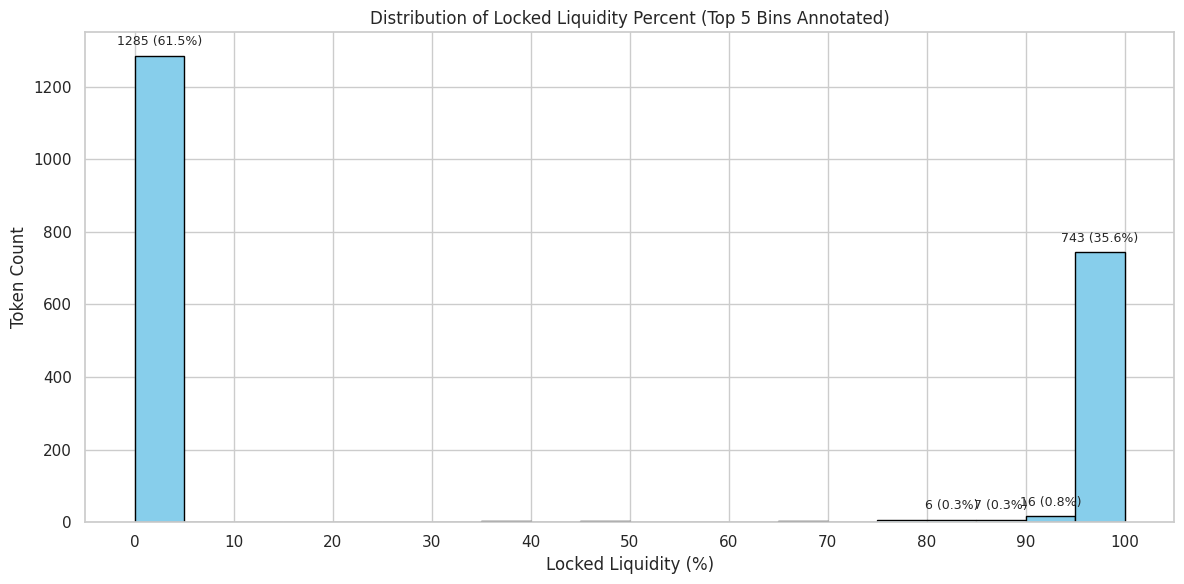

In [13]:
# Clean the data
locked_liquidity = pd.to_numeric(df_liquidity['locked_liquidity_percent'], errors='coerce').clip(0, 100)
df_liquidity['locked_liquidity_percent_cleaned'] = locked_liquidity

# Create histogram data
bin_edges = np.linspace(0, 100, 21)  # 20 bins (5% width)
counts, edges = np.histogram(locked_liquidity.dropna(), bins=bin_edges)
bin_centers = 0.5 * (edges[1:] + edges[:-1])
total = counts.sum()

# Identify indices of top 5 bins
top_5_indices = np.argsort(counts)[-5:]

# Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(bin_centers, counts, width=5, align='center', color='skyblue', edgecolor='black')

# Annotate only top 5 bars
for i, bar in enumerate(bars):
    if i in top_5_indices and counts[i] > 0:
        percentage = (counts[i] / total) * 100
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + total * 0.01,
                 f'{counts[i]} ({percentage:.1f}%)',
                 ha='center', va='bottom', fontsize=9)

# Labels and title
plt.title('Distribution of Locked Liquidity Percent (Top 5 Bins Annotated)')
plt.xlabel('Locked Liquidity (%)')
plt.ylabel('Token Count')
plt.xticks(np.arange(0, 110, 10))
plt.tight_layout()
plt.show()

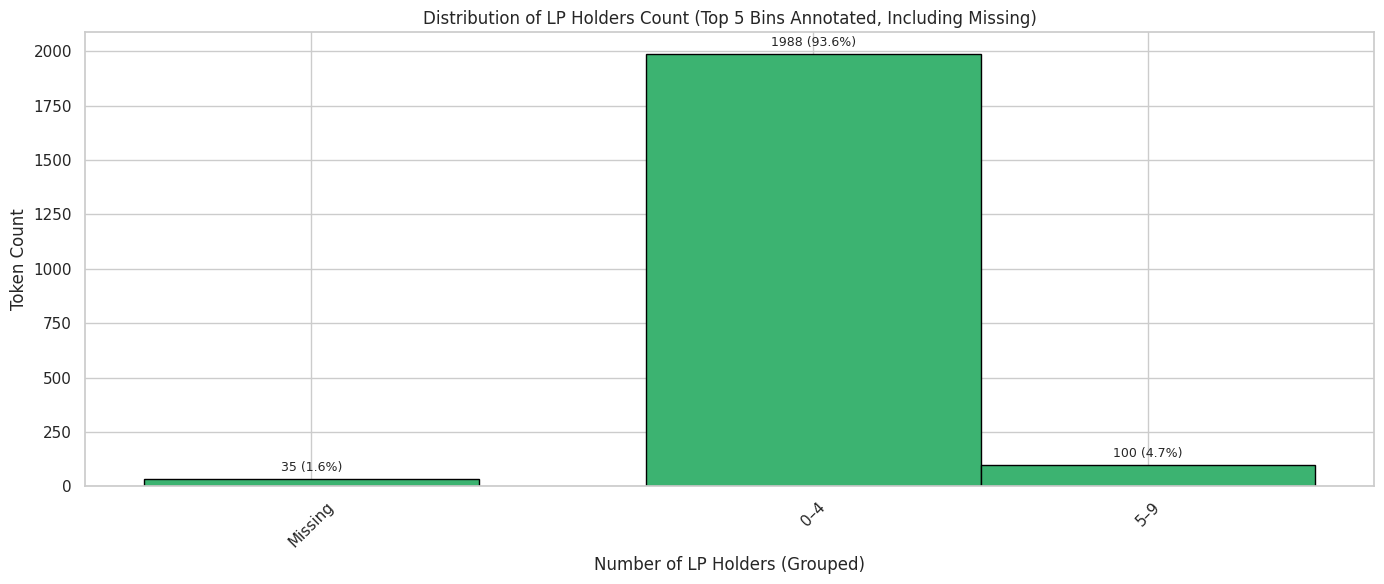

In [14]:
# Convert to numeric
df_liquidity['lp_holders_count_cleaned'] = pd.to_numeric(df_liquidity['lp_holders_count'], errors='coerce')

# Separate non-null and null values
lp_holders_data = df_liquidity['lp_holders_count_cleaned'].dropna()
missing_count = df_liquidity['lp_holders_count_cleaned'].isna().sum()

# Create histogram bins (bin width = 5, capped at 100 for readability)
max_val = lp_holders_data.max()
bin_edges = np.arange(0, min(max_val, 100) + 5, 5)
counts, edges = np.histogram(lp_holders_data, bins=bin_edges)
bin_centers = 0.5 * (edges[:-1] + edges[1:])

# Add the missing values as an extra bin on the left
bin_centers = np.insert(bin_centers, 0, -5)  # use -5 as placeholder for "Missing"
counts = np.insert(counts, 0, missing_count)
labels = ['Missing'] + [f"{int(edges[i])}–{int(edges[i+1]-1)}" for i in range(len(edges)-1)]
total = counts.sum()

# Identify top 5 bins including missing
top_5_indices = np.argsort(counts)[-5:]

# Plot
plt.figure(figsize=(14, 6))
bars = plt.bar(bin_centers, counts, width=5, color='mediumseagreen', edgecolor='black')

# Annotate only top 5 bins
for i, bar in enumerate(bars):
    if i in top_5_indices and counts[i] > 0:
        percentage = (counts[i] / total) * 100
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + total * 0.01,
                 f'{counts[i]} ({percentage:.1f}%)',
                 ha='center', va='bottom', fontsize=9)

# Adjust x-axis
xtick_labels = labels
xtick_positions = bin_centers
plt.xticks(ticks=xtick_positions, labels=xtick_labels, rotation=45)

# Labels and title
plt.title("Distribution of LP Holders Count (Top 5 Bins Annotated, Including Missing)")
plt.xlabel("Number of LP Holders (Grouped)")
plt.ylabel("Token Count")
plt.tight_layout()
plt.show()

Tokens with LP holders >10%: 2052/2122 (96.7%)


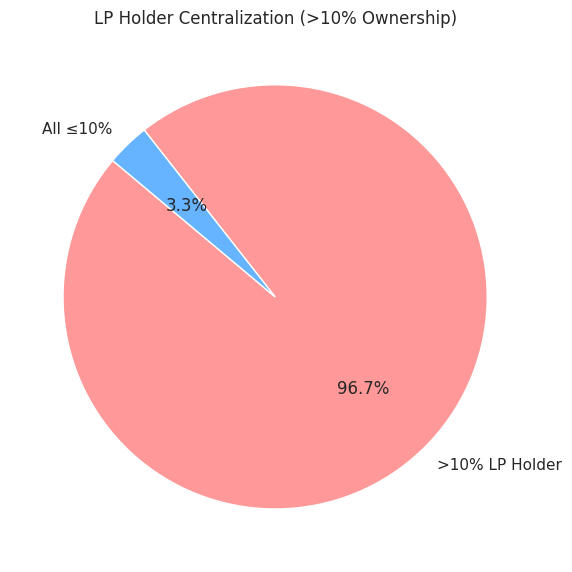

In [15]:
# Focus on holders with >10% of LP
df_top_lp_holders = df_lp_holders[df_lp_holders['percent'] > 10]

# Count how many tokens have LPs held >10% by a single address
top_lp_count = df_top_lp_holders['token_address'].nunique()
total_lp_tokens = df_lp_holders['token_address'].nunique()

print(f"Tokens with LP holders >10%: {top_lp_count}/{total_lp_tokens} ({top_lp_count/total_lp_tokens:.1%})")

# Plot pie chart
labels = ['>10% LP Holder', 'All ≤10%']
sizes = [top_lp_count, total_lp_tokens - top_lp_count]

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=['#ff9999','#66b3ff'], startangle=140)
plt.title("LP Holder Centralization (>10% Ownership)")
plt.tight_layout()
plt.show()


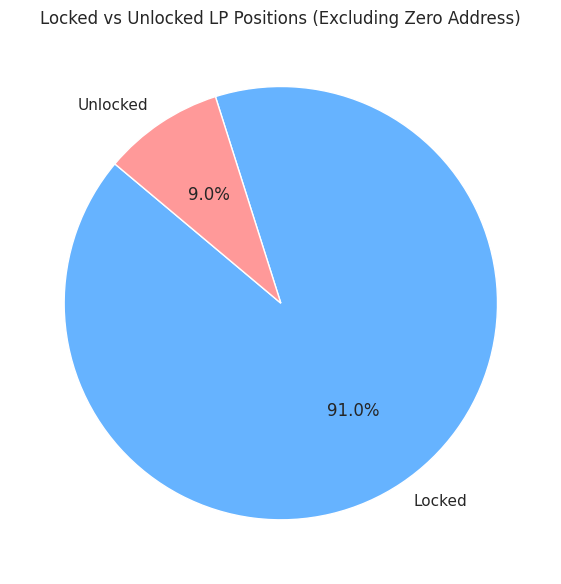

In [16]:
# Clean numeric fields
df_lp_holders['percent'] = pd.to_numeric(df_lp_holders['percent'], errors='coerce')
df_lp_holders['balance'] = pd.to_numeric(df_lp_holders['balance'], errors='coerce')

# Drop rows with missing percent
df_lp_holders = df_lp_holders.dropna(subset=['percent'])

lp_lock_counts = df_lp_holders['is_locked'].value_counts()

# Exclude the 0x000...000 address
zero_address = '0x0000000000000000000000000000000000000000'
df_lp_holders_filtered = df_lp_holders[df_lp_holders['address'].str.lower() != zero_address]

# Locked vs Unlocked LP Distribution (Filtered)
lp_lock_counts = df_lp_holders_filtered['is_locked'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(lp_lock_counts, labels=['Locked', 'Unlocked'], autopct='%1.1f%%', startangle=140,
        colors=['#66b3ff', '#ff9999'])
plt.title("Locked vs Unlocked LP Positions (Excluding Zero Address)")
plt.tight_layout()
plt.show()

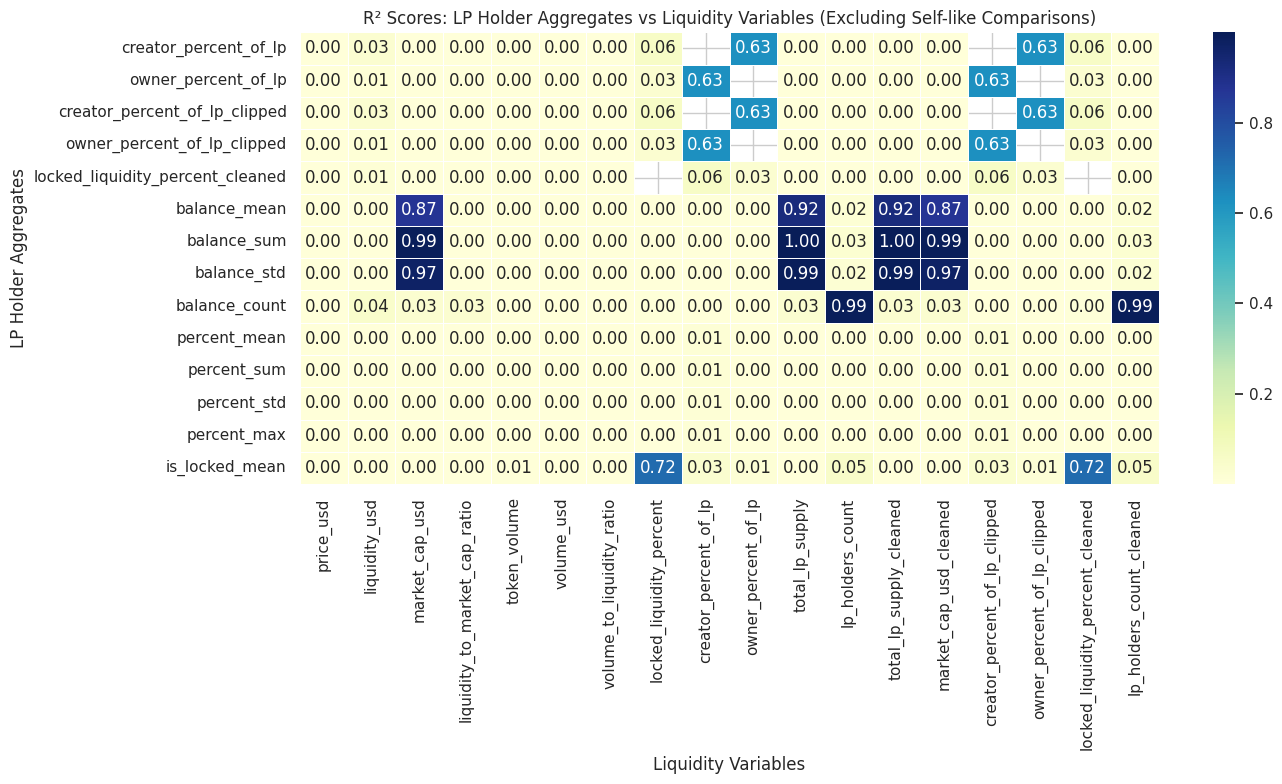

In [17]:
import re
# Exclude zero address
df_lp_holders = df_lp_holders[df_lp_holders['address'] != '0x0000000000000000000000000000000000000000']

# Aggregate LP holders per token
agg_lp_holders = df_lp_holders.groupby('token_address').agg({
    'balance': ['mean', 'sum', 'std', 'count'],
    'percent': ['mean', 'sum', 'std', 'max'],
    'is_locked': 'mean'  # ratio of locked holders
})

# Flatten MultiIndex columns
agg_lp_holders.columns = ['_'.join(col) for col in agg_lp_holders.columns]
agg_lp_holders.reset_index(inplace=True)

# Drop categorical and boolean columns
liquidity_numeric = df_liquidity.select_dtypes(include='number').copy()

# Keep token_address for merging
liquidity_numeric['token_address'] = df_liquidity['token_address']

# Merge on token_address
merged_df = pd.merge(liquidity_numeric, agg_lp_holders, on='token_address', how='inner')

# Drop rows with NaNs (optional)
merged_df = merged_df.dropna()

# Helper to strip variable suffixes
def base_var_name(var):
    return re.sub(r'_(cleaned|clipped|mean|sum|std|max|count)$', '', var)

# Separate variable lists
lp_cols = [col for col in merged_df.columns if any(stat in col for stat in ['balance_', 'percent_', 'is_locked'])]
liq_cols = [col for col in liquidity_numeric.columns if col != 'token_address']

# Initialize R² matrix
r2_df = pd.DataFrame(index=lp_cols, columns=liq_cols)

# Compute R², skipping variables with matching base names
for y_col in lp_cols:
    for x_col in liq_cols:
        if base_var_name(x_col) == base_var_name(y_col):
            r2_df.loc[y_col, x_col] = np.nan
            continue
        X = merged_df[[x_col]]
        y = merged_df[y_col]
        if len(X) > 2:
            model = LinearRegression().fit(X, y)
            r2 = model.score(X, y)
            r2_df.loc[y_col, x_col] = r2

# Convert to float
r2_df = r2_df.astype(float)

# Plot heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(r2_df, annot=True, cmap="YlGnBu", fmt=".2f", linewidths=0.5, mask=r2_df.isnull())
plt.title("R² Scores: LP Holder Aggregates vs Liquidity Variables (Excluding Self-like Comparisons)")
plt.xlabel("Liquidity Variables")
plt.ylabel("LP Holder Aggregates")
plt.tight_layout()
plt.show()
